# Recommender Systems Lab: Building a Movie Recommendation Engine

## Lab Overview

In this hands-on session, we'll build a complete movie recommendation system using real data. You'll implement multiple algorithms, evaluate their performance, and understand the business implications of different approaches.

**Business Context**: You're consulting for a streaming service looking to increase user engagement through personalized recommendations.

---

## Setup and Imports


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# For data processing and algorithms
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
from collections import defaultdict
import urllib.request
import zipfile
import os

print("✅ Setup complete! Let's build some recommender systems!")

✅ Setup complete! Let's build some recommender systems!


---

## Part 1: Data Loading and Exploration

In this section, we'll load the MovieLens dataset and conduct exploratory data analysis to understand user behavior patterns, movie popularity distributions, and data quality. This foundational analysis will inform our recommendation strategy and help identify key business insights about user engagement.

#### 1.1 Load the MovieLens Dataset

In [5]:
# Load the MovieLens 100K dataset with movie information
# Download and extract the dataset
url = "http://files.grouplens.org/datasets/movielens/ml-100k.zip"
urllib.request.urlretrieve(url, "movielens.zip")

with zipfile.ZipFile("movielens.zip", "r") as zip_ref:
    zip_ref.extractall("movielens")

# Load ratings data
ratings_df = pd.read_csv('movielens/ml-100k/u.data', sep='\t',
                        names=['user_id', 'item_id', 'rating', 'timestamp'])
ratings_df['timestamp'] = pd.to_datetime(ratings_df['timestamp'], unit='s')

# Load movie information for content-based filtering
movies_df = pd.read_csv('movielens/ml-100k/u.item', sep='|', encoding='latin-1',
                       names=['item_id', 'title', 'release_date', 'video_release_date',
                             'imdb_url', 'unknown', 'Action', 'Adventure', 'Animation',
                             'Children', 'Comedy', 'Crime', 'Documentary', 'Drama',
                             'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery',
                             'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'])

# Extract genres
genre_columns = ['Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime',
                'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical',
                'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']

print(f"📊 Dataset shape: {ratings_df.shape}")
print(f"👥 Number of users: {ratings_df['user_id'].nunique()}")
print(f"🎬 Number of movies: {ratings_df['item_id'].nunique()}")
print(f"⭐ Rating scale: {ratings_df['rating'].min()} to {ratings_df['rating'].max()}")
print(f"📅 Date range: {ratings_df['timestamp'].min()} to {ratings_df['timestamp'].max()}")
print(f"\n🏷️ Number of genres: {len(genre_columns)}")

📊 Dataset shape: (100000, 4)
👥 Number of users: 943
🎬 Number of movies: 1682
⭐ Rating scale: 1 to 5
📅 Date range: 1997-09-20 03:05:10 to 1998-04-22 23:10:38

🏷️ Number of genres: 18


#### 1.2 Exploratory Data Analysis

In [6]:
print("⭐️ Aperçu du dataset des notes (ratings_df) :")
print(ratings_df.head())

print("\n🎬 Aperçu du dataset des films (movies_df) :")
print(movies_df.head())

⭐️ Aperçu du dataset des notes (ratings_df) :
   user_id  item_id  rating           timestamp
0      196      242       3 1997-12-04 15:55:49
1      186      302       3 1998-04-04 19:22:22
2       22      377       1 1997-11-07 07:18:36
3      244       51       2 1997-11-27 05:02:03
4      166      346       1 1998-02-02 05:33:16

🎬 Aperçu du dataset des films (movies_df) :
   item_id              title release_date  video_release_date  \
0        1   Toy Story (1995)  01-Jan-1995                 NaN   
1        2   GoldenEye (1995)  01-Jan-1995                 NaN   
2        3  Four Rooms (1995)  01-Jan-1995                 NaN   
3        4  Get Shorty (1995)  01-Jan-1995                 NaN   
4        5     Copycat (1995)  01-Jan-1995                 NaN   

                                            imdb_url  unknown  Action  \
0  http://us.imdb.com/M/title-exact?Toy%20Story%2...        0       0   
1  http://us.imdb.com/M/title-exact?GoldenEye%20(...        0       1   
2  ht

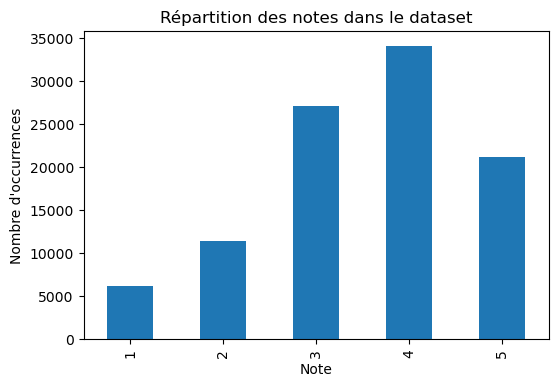

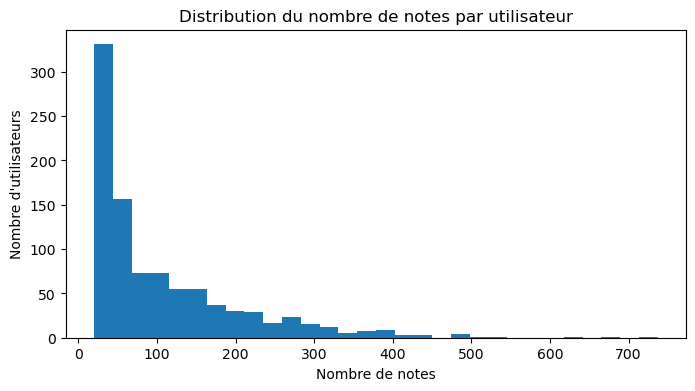

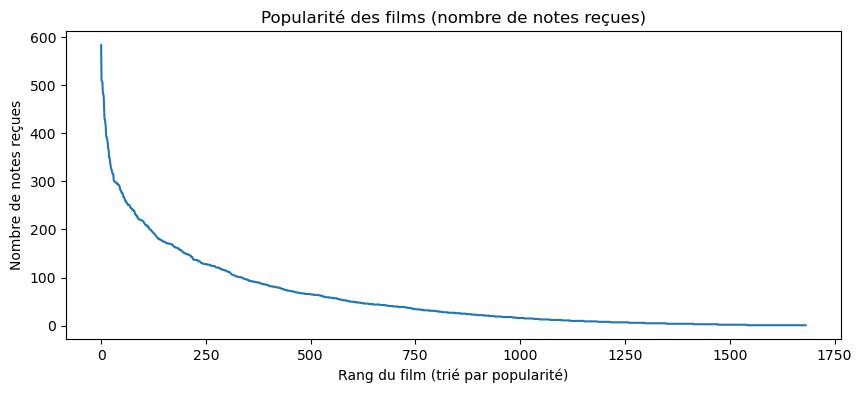

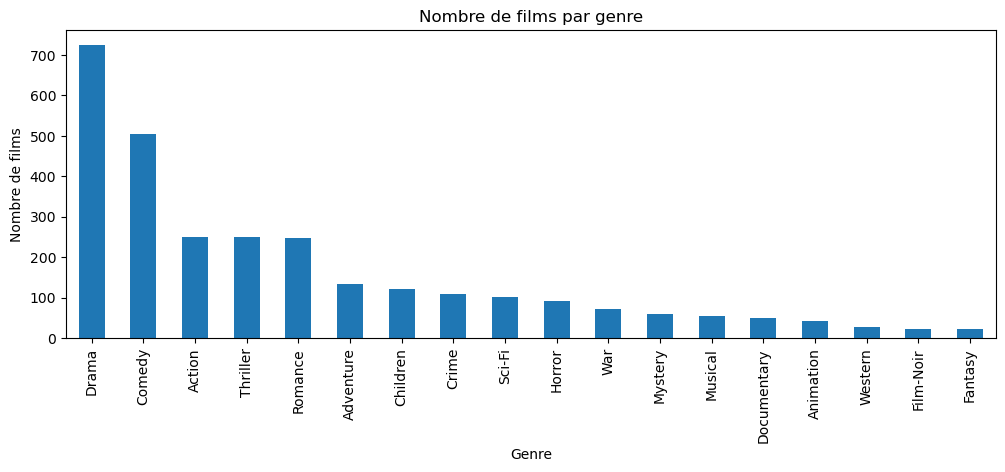

In [7]:
# TODO: Complete the visualization code

# 1. Create a bar chart showing how many times each rating value (1-5) appears in the dataset
plt.figure(figsize=(6,4))
ratings_df['rating'].value_counts().sort_index().plot(kind='bar')
plt.title("Répartition des notes dans le dataset")
plt.xlabel("Note")
plt.ylabel("Nombre d'occurrences")
plt.show()

# 2. Create a histogram showing the distribution of how many ratings each user has made
plt.figure(figsize=(8,4))
ratings_per_user = ratings_df.groupby('user_id').size()
plt.hist(ratings_per_user, bins=30)
plt.title("Distribution du nombre de notes par utilisateur")
plt.xlabel("Nombre de notes")
plt.ylabel("Nombre d'utilisateurs")
plt.show()

# 3. Create a line plot showing movies ranked by popularity (number of ratings received)
plt.figure(figsize=(10,4))
ratings_per_movie = ratings_df.groupby('item_id').size().sort_values(ascending=False).reset_index(drop=True)
plt.plot(ratings_per_movie.values)
plt.title("Popularité des films (nombre de notes reçues)")
plt.xlabel("Rang du film (trié par popularité)")
plt.ylabel("Nombre de notes reçues")
plt.show()

# 4. Create a bar chart showing how many movies belong to each genre category
plt.figure(figsize=(12,4))
genre_counts = movies_df[genre_columns].sum().sort_values(ascending=False)
genre_counts.plot(kind='bar')
plt.title("Nombre de films par genre")
plt.xlabel("Genre")
plt.ylabel("Nombre de films")
plt.show()


#### 💡 Business Insight Questions

In [8]:
# TODO: Let's analyze some business-relevant patterns

# 1. What percentage of users are "power users" (>100 ratings)?
user_rating_counts = ratings_df.groupby('user_id').size()
n_users = user_rating_counts.size
n_power_users = (user_rating_counts > 100).sum()
power_user_pct = 100 * n_power_users / n_users

print(f"👤 Power users (>100 ratings): {power_user_pct:.2f}%")

# 2. What percentage of movies have very few ratings (<10)?
movie_rating_counts = ratings_df.groupby('item_id').size()
n_movies = movie_rating_counts.size
n_rare_movies = (movie_rating_counts < 10).sum()
rare_movie_pct = 100 * n_rare_movies / n_movies

print(f"🎬 Rare movies (<10 ratings): {rare_movie_pct:.2f}%")

# 3. Calculate the percentage of ratings that come from the top 20% most active users
# This demonstrates the 80/20 rule in user engagement
user_rating_counts_sorted = user_rating_counts.sort_values(ascending=False)
top_20pct_n = int(0.2 * n_users)

# Prendre les top 20% utilisateurs
top_20pct_users = user_rating_counts_sorted.iloc[:top_20pct_n]
ratings_from_top_20pct = top_20pct_users.sum()
total_ratings = ratings_df.shape[0]
pct_ratings_from_top_20pct = 100 * ratings_from_top_20pct / total_ratings

print(f"📊 Percentage of ratings from top 20% users: {pct_ratings_from_top_20pct:.2f}%")

👤 Power users (>100 ratings): 38.28%
🎬 Rare movies (<10 ratings): 31.51%
📊 Percentage of ratings from top 20% users: 51.36%


## Part 2: Building Baseline Recommenders

Now we'll implement our first recommendation algorithms, starting with simple but effective baseline approaches. These methods provide a foundation for comparison and handle common challenges like cold start problems for new users.

#### 2.1 Popularity-Based Recommender

In [45]:
class PopularityRecommender:
    """
    Simple recommender that suggests the most popular movies.
    Good baseline and handles cold start for new users.
    """
    def __init__(self, min_ratings=50):
        self.min_ratings = min_ratings
        self.popular_movies = None

    def fit(self, ratings_df):
        # Calculer le nombre de notes et la note moyenne pour chaque film
        movie_stats = ratings_df.groupby('item_id')['rating'].agg(['count', 'mean']).reset_index()
        movie_stats.rename(columns={'count': 'num_ratings', 'mean': 'avg_rating'}, inplace=True)

        # Ne garder que les films avec au moins min_ratings notes
        movie_stats = movie_stats[movie_stats['num_ratings'] >= self.min_ratings]

        # Calculer le log du nombre total de ratings
        num_ratings_total = ratings_df.shape[0]
        log_num_ratings_total = np.log(num_ratings_total)

        # Score de popularité pondéré
        movie_stats['popularity'] = (
            0.7 * movie_stats['avg_rating'] +
            0.3 * (np.log(movie_stats['num_ratings']) / log_num_ratings_total)
        )

        # Trier par popularité décroissante
        movie_stats = movie_stats.sort_values(by='popularity', ascending=False)

        # Sauvegarder la liste dans l'objet
        self.popular_movies = movie_stats.reset_index(drop=True)
        return self

    def recommend_for_user(self, user_id=None, n=10):
        """Return top N popular movies (user_id is ignored for popularity-based)"""
        return self.popular_movies.head(n)

In [46]:
def add_movie_titles(recommendations_df, movies_df):
    """Helper function to add movie titles to recommendations"""
    return recommendations_df.merge(movies_df[['item_id', 'title']], on='item_id', how='left')

Generate recommendations with the popularity recommender

In [56]:
pop_rec = PopularityRecommender(min_ratings=50)
pop_rec.fit(ratings_df)

print("🏆 Top 10 Popular Movies:")
popular_recommendations = pop_rec.recommend_for_user(n=10)

# Add movie titles
popular_with_titles = add_movie_titles(popular_recommendations, movies_df)
print(popular_with_titles)

🏆 Top 10 Popular Movies:
   item_id  num_ratings  avg_rating  popularity  \
0      318          298        4.47        3.27   
1      408          112        4.49        3.27   
2      483          243        4.46        3.26   
3       64          283        4.45        3.26   
4      169          118        4.47        3.25   
5      114           67        4.45        3.22   
6       50          583        4.36        3.22   
7       12          267        4.39        3.22   
8      603          209        4.39        3.21   
9      178          125        4.34        3.17   

                                               title  
0                            Schindler's List (1993)  
1                              Close Shave, A (1995)  
2                                  Casablanca (1942)  
3                   Shawshank Redemption, The (1994)  
4                         Wrong Trousers, The (1993)  
5  Wallace & Gromit: The Best of Aardman Animatio...  
6                           

---

## Part 3: Collaborative Filtering

In this section, we'll build recommenders based on collaborative filtering, namely user-based collaborative filtering and a more sophisticated approach using matrix factorization (SVD) to discover hidden patterns in user preferences. SVD can uncover latent factors that explain user-item interactions and often provides superior personalization compared to simpler methods.

#### 3.1 User-Based Collaborative Filtering

In [26]:
class UserBasedCFRecommender:
    def __init__(self, n_similar_users=50):
        self.n_similar_users = n_similar_users
        self.user_item_matrix = None

    def fit(self, ratings_df):
        """Build user-item matrix from ratings data"""
        self.user_item_matrix = ratings_df.pivot_table(
            index='user_id',
            columns='item_id',
            values='rating'
        ).fillna(0)
        
        return self

    def recommend_for_user(self, user_id, n=10):
        """
        Recommend movies based on similar users' preferences
        """
        if user_id not in self.user_item_matrix.index:
            return pd.DataFrame(columns=['item_id', 'predicted_score'])

        # Get the target user's ratings
        target_user_ratings = self.user_item_matrix.loc[user_id].values.reshape(1, -1)

        # TODO: Calculate cosine similarity between target user and all other users
        # Hint: Use cosine_similarity from sklearn with proper reshaping
        # Expected: user_similarities should be a 1D array of similarity scores
        # YOUR CODE HERE
        user_sim_matrix = cosine_similarity(target_user_ratings, self.user_item_matrix.values)
        user_similarities = user_sim_matrix.flatten()

        # Get indices of most similar users (excluding the user themselves)
        similar_users_indices = np.argsort(user_similarities)[::-1][1:self.n_similar_users+1]
        similar_users = self.user_item_matrix.index[similar_users_indices]

        # Generate recommendations based on what similar users liked
        # but the target user hasn't seen
        recommendations = defaultdict(float)

        for idx, similar_user in enumerate(similar_users):
            similarity = user_similarities[similar_users_indices[idx]]
            similar_user_ratings = self.user_item_matrix.loc[similar_user]

            # Find movies the similar user rated highly but target user hasn't seen
            for movie_id, rating in similar_user_ratings.items():
                col_idx = self.user_item_matrix.columns.get_loc(movie_id)
                if target_user_ratings[0, col_idx] == 0 and rating >= 4:
                    recommendations[movie_id] += rating * similarity

        # Sort and return top N
        top_recommendations = sorted(recommendations.items(), key=lambda x: x[1], reverse=True)[:n]
        return pd.DataFrame(top_recommendations, columns=['item_id', 'predicted_score'])

Generate recommendations with the user-based CF recommender

cf_recommender Shape: (943, 1682)


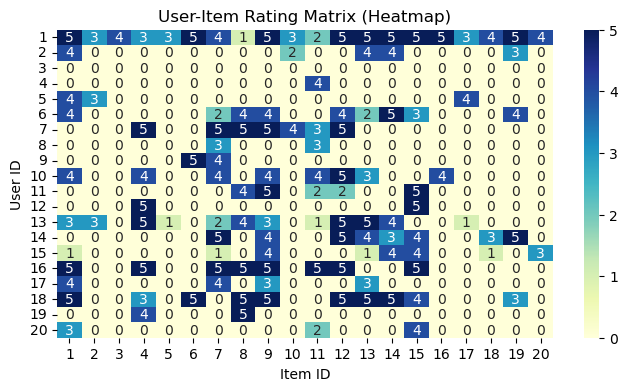

👤 Recommendations for User 486:
   item_id  predicted_score                       title
0      313        39.194804              Titanic (1997)
1      340        30.215441        Boogie Nights (1997)
2      283        26.382337                 Emma (1996)
3      272        25.690847    Good Will Hunting (1997)
4     1067        24.086362        Bottle Rocket (1996)
5     1012        23.402515        Private Parts (1997)
6      126        21.968521  Spitfire Grill, The (1996)
7       19        21.709865       Antonia's Line (1995)
8      118        21.509981              Twister (1996)
9      410        18.884692              Kingpin (1996)


In [32]:
cf_recommender = UserBasedCFRecommender(n_similar_users=50)
cf_recommender.fit(ratings_df)

print("cf_recommender Shape:", cf_recommender.user_item_matrix.shape)

# Plot heatmap (petite portion si ta matrice est grande)
plt.figure(figsize=(8, 4))
sns.heatmap(cf_recommender.user_item_matrix.iloc[:20, :20], cmap="YlGnBu", annot=True, fmt="g")
plt.title("User-Item Rating Matrix (Heatmap)")
plt.xlabel("Item ID")
plt.ylabel("User ID")
plt.show()

# Test with a sample user
#sample_user = ratings_df['user_id'].sample(1).iloc[0]
sample_user = 486
print(f"👤 Recommendations for User {sample_user}:")


# Get recommendations using the class method
user_cf_recs = cf_recommender.recommend_for_user(sample_user, n=10)
# Add movie titles
user_cf_recs_with_titles = add_movie_titles(user_cf_recs, movies_df)
print(user_cf_recs_with_titles)

### 3.2 Matrix Factorization with SVD

In [27]:
class SVDRecommender:
    """
    Efficient SVD-based recommender using scipy's optimized implementation
    """
    def __init__(self, n_factors=50):
        self.n_factors = n_factors
        self.user_item_matrix = None
        self.predicted_ratings = None
        self.user_means = None
        self.user_ids = None
        self.item_ids = None

    def fit(self, train_df):
        """Train SVD model and store reference data"""
        self.ratings_df = train_df

        # Create user-item matrix
        self.user_item_matrix = train_df.pivot_table(
            index='user_id',
            columns='item_id',
            values='rating'
        )

        # Store indices for lookup
        self.user_ids = self.user_item_matrix.index
        self.item_ids = self.user_item_matrix.columns

        # Fill NaN and normalize
        matrix_filled = self.user_item_matrix.fillna(0)
        self.user_means = np.mean(matrix_filled.values, axis=1)
        matrix_normalized = matrix_filled.values - self.user_means.reshape(-1, 1)

        # Apply SVD
        U, sigma, Vt = svds(csr_matrix(matrix_normalized), k=self.n_factors)
        sigma = np.diag(sigma)

        # Reconstruct ratings matrix
        self.predicted_ratings = np.dot(np.dot(U, sigma), Vt) + self.user_means.reshape(-1, 1)

        return self

    def predict(self, user_id, item_id):
        """Predict rating for user-item pair(s)"""
        if isinstance(user_id, (list, np.ndarray)):
            return [self._predict_single(u, i) for u, i in zip(user_id, item_id)]
        else:
            return self._predict_single(user_id, item_id)

    def _predict_single(self, user_id, item_id):
        """Predict rating for single user-item pair"""
        try:
            user_idx = self.user_ids.get_loc(user_id)
            item_idx = self.item_ids.get_loc(item_id)
            prediction = self.predicted_ratings[user_idx, item_idx]
            return np.clip(prediction, 1, 5)
        except KeyError:
            # Return global mean for unknown users/items
            return np.mean(self.user_means) + 3  # Reasonable default

    def recommend_for_user(self, user_id, n=10):
        """Get top N recommendations for a user"""
        if user_id not in self.user_ids:
            return pd.DataFrame(columns=['item_id', 'predicted_rating', 'title'])

        # Get user index
        user_idx = self.user_ids.get_loc(user_id)
        user_predictions = self.predicted_ratings[user_idx]

        # Get items the user has already rated (need to store ratings_df)
        if hasattr(self, 'ratings_df'):
            user_items = self.ratings_df[self.ratings_df['user_id'] == user_id]['item_id'].values
        else:
            user_items = []

        # Create recommendations
        recommendations = []
        for idx, item_id in enumerate(self.item_ids):
            if item_id not in user_items:
                recommendations.append((item_id, user_predictions[idx]))

        # Sort and return top N
        recommendations.sort(key=lambda x: x[1], reverse=True)
        rec_df = pd.DataFrame(recommendations[:n], columns=['item_id', 'predicted_rating'])
        return rec_df

Generate recommendations with the SVD recommender

In [30]:
# Usage
print("🔧 Training SVD model...")
train_data = ratings_df.sample(frac=0.8, random_state=42)
test_data = ratings_df.drop(train_data.index)

svd_model = SVDRecommender(n_factors=50)
svd_model.fit(train_data)
print("✅ SVD model trained!")

# Test recommendations
#test_user = ratings_df['user_id'].sample(1).iloc[0]
test_user = 486
print(f"🎯 SVD Recommendations for User {test_user}:")

svd_recommendations = svd_model.recommend_for_user(test_user, n=10)
svd_recommendations = add_movie_titles(svd_recommendations, movies_df)

print(svd_recommendations)

🔧 Training SVD model...
✅ SVD model trained!
🎯 SVD Recommendations for User 486:
   item_id  predicted_rating                       title
0      276          3.238860    Leaving Las Vegas (1995)
1      116          2.649137    Cold Comfort Farm (1995)
2        7          2.386286       Twelve Monkeys (1995)
3      283          2.341900                 Emma (1996)
4      744          2.328784      Michael Collins (1996)
5      475          2.273868        Trainspotting (1996)
6      301          2.256865             In & Out (1997)
7      282          2.215306      Time to Kill, A (1996)
8      248          2.110142  Grosse Pointe Blank (1997)
9      340          1.987195        Boogie Nights (1997)


---

## Part 4: Content-Based Filtering

In this section, we'll build recommenders that leverage movie characteristics like genres and release year to find similar content. Content-based approaches excel at recommending items similar to what users have already enjoyed and can handle new items effectively.

#### 4.1 Feature Engineering for Movies

In [33]:
# Prepare content features for movies
def prepare_movie_features(movies_df):
    """
    Create feature vectors for movies based on genres and other attributes
    """
    movies_df = movies_df.copy()
    # Genre features (already binary)
    genre_features = movies_df[genre_columns].values

    # Extract year from release date
    movies_df['year'] = pd.to_datetime(movies_df['release_date'], errors='coerce').dt.year
    movies_df['year'].fillna(movies_df['year'].median(), inplace=True)

    # Normalize year to 0-1 range
    min_year = movies_df['year'].min()
    max_year = movies_df['year'].max()
    movies_df['year_normalized'] = (movies_df['year'] - min_year) / (max_year - min_year)

    # Combine all features
    feature_matrix = np.column_stack([
        genre_features,
        movies_df['year_normalized'].values.reshape(-1, 1)
    ])

    return feature_matrix, movies_df

# Prepare features
movie_features, movies_enhanced = prepare_movie_features(movies_df)
print(f"📐 Movie feature matrix shape: {movie_features.shape}")
print(f"📊 Features include: {len(genre_columns)} genres + 1 year feature")

📐 Movie feature matrix shape: (1682, 19)
📊 Features include: 18 genres + 1 year feature


In [34]:
import pandas as pd

# Liste des noms de colonnes (genres + year)
feature_names = genre_columns + ['year_normalized']

# Conversion en DataFrame
features_df = pd.DataFrame(movie_features, columns=feature_names)

# Optionnel : ajoute l'ID ou le titre du film
features_df.insert(0, 'title', movies_enhanced['title'].values)
features_df.insert(1, 'item_id', movies_enhanced['item_id'].values)

# Affichage des 20 premières lignes joliment
pd.set_option('display.float_format', lambda x: f'{x:,.2f}')  # Formatage à 2 décimales
print(features_df.head(20).to_string(index=False))

                                               title  item_id  Action  Adventure  Animation  Children  Comedy  Crime  Documentary  Drama  Fantasy  Film-Noir  Horror  Musical  Mystery  Romance  Sci-Fi  Thriller  War  Western  year_normalized
                                    Toy Story (1995)        1    0.00       0.00       1.00      1.00    1.00   0.00         0.00   0.00     0.00       0.00    0.00     0.00     0.00     0.00    0.00      0.00 0.00     0.00             0.96
                                    GoldenEye (1995)        2    1.00       1.00       0.00      0.00    0.00   0.00         0.00   0.00     0.00       0.00    0.00     0.00     0.00     0.00    0.00      1.00 0.00     0.00             0.96
                                   Four Rooms (1995)        3    0.00       0.00       0.00      0.00    0.00   0.00         0.00   0.00     0.00       0.00    0.00     0.00     0.00     0.00    0.00      1.00 0.00     0.00             0.96
                                   G

#### 4.2 Content-Based Item Similarity

In [35]:
class ContentBasedRecommender:
    def __init__(self, movies_df, movie_features):
        self.movies_df = movies_df
        self.movie_features = movie_features
        self.item_similarities = None
        self.ratings_df = None

    def fit(self, ratings_df=None):
        """Calculate item-item similarities and store ratings data"""
        if ratings_df is not None:
            self.ratings_df = ratings_df

        # TODO: Compute item similarities between all movies
        # Hint: Use cosine similarity between `self.movie_features`, and store the result in `self.item_similarities`
        # YOUR CODE HERE
        self.item_similarities = cosine_similarity(self.movie_features)
        return self

    def get_similar_items(self, item_id, n=10):
        """Find n most similar items to the given item"""
        if item_id not in self.movies_df['item_id'].values:
            return pd.DataFrame(columns=['item_id', 'title', 'similarity_score'])

        # Get index of the movie
        idx = self.movies_df[self.movies_df['item_id'] == item_id].index[0]

        # Get similarity scores and sort
        sim_scores = list(enumerate(self.item_similarities[idx]))
        sim_scores.sort(key=lambda x: x[1], reverse=True)

        # Get top N similar movies (excluding itself)
        similar_indices = [i[0] for i in sim_scores[1:n+1]]
        similar_movies = self.movies_df.iloc[similar_indices][['item_id', 'title']].copy()
        similar_movies['similarity_score'] = [i[1] for i in sim_scores[1:n+1]]

        return similar_movies

    def recommend_for_user(self, user_id, n=10):
        """Recommend items for a user (now uses stored ratings_df)"""
        if self.ratings_df is None:
            raise ValueError("No ratings data available. Call fit(ratings_df) first.")

        # Get user's rated movies
        user_movies = self.ratings_df[self.ratings_df['user_id'] == user_id]
        if len(user_movies) == 0:
            return pd.DataFrame(columns=['item_id', 'content_score', 'title'])

        # Get highly rated movies by the user
        liked_movies = user_movies[user_movies['rating'] >= 4]['item_id'].values
        if len(liked_movies) == 0:
            liked_movies = user_movies.nlargest(3, 'rating')['item_id'].values

        # Find similar movies to what the user liked
        # Aggregate similarity scores across all liked movies
        recommendations = defaultdict(float)

        for movie_id in liked_movies:
            if movie_id in self.movies_df['item_id'].values:
                similar_movies = self.get_similar_items(movie_id, n=20)
                for _, row in similar_movies.iterrows():
                    # Don't recommend movies the user has already seen
                    if row['item_id'] not in user_movies['item_id'].values:
                        recommendations[row['item_id']] += row['similarity_score']

        # Sort and get top N
        top_recommendations = sorted(recommendations.items(), key=lambda x: x[1], reverse=True)[:n]
        result_df = pd.DataFrame(top_recommendations, columns=['item_id', 'content_score'])
        result_df = result_df.merge(self.movies_df[['item_id', 'title']], on='item_id')

        return result_df


Generate recommendations with the content-based recommender

In [36]:
# Create and test content-based recommender
content_rec = ContentBasedRecommender(movies_enhanced, movie_features)
content_rec.fit(ratings_df)

In [37]:
# Test: Find similar movies to Star Wars
star_wars_id = movies_df[movies_df['title'].str.contains('Star Wars', case=False)]['item_id'].iloc[0]
print(f"🎬 Movies similar to '{movies_df[movies_df['item_id']==star_wars_id]['title'].iloc[0]}':")
print(content_rec.get_similar_items(star_wars_id, n=10))

🎬 Movies similar to 'Star Wars (1977)':
     item_id                                          title  similarity_score
180      181                      Return of the Jedi (1983)              0.99
171      172                Empire Strikes Back, The (1980)              0.92
270      271                       Starship Troopers (1997)              0.90
497      498                      African Queen, The (1951)              0.89
448      449           Star Trek: The Motion Picture (1979)              0.80
227      228            Star Trek: The Wrath of Khan (1982)              0.80
228      229     Star Trek III: The Search for Spock (1984)              0.80
229      230           Star Trek IV: The Voyage Home (1986)              0.80
449      450         Star Trek V: The Final Frontier (1989)              0.80
226      227  Star Trek VI: The Undiscovered Country (1991)              0.80


In [38]:
# Test: Recommendations for a user
print(f"\n📚 Content-based recommendations for User {sample_user}:")
print(content_rec.recommend_for_user(sample_user, n=10))


📚 Content-based recommendations for User 486:
   item_id  content_score                     title
0      272           7.81  Good Will Hunting (1997)
1      296           7.81       Promesse, La (1996)
2      310           7.81     Rainmaker, The (1997)
3      330           7.81                187 (1997)
4      340           7.81      Boogie Nights (1997)
5      344           7.81       Apostle, The (1997)
6      534           7.81          Traveller (1997)
7      536           7.81            Ponette (1996)
8      750           7.81            Amistad (1997)
9      865           7.81     Ice Storm, The (1997)


#### 4.3 Analyzing Content Patterns

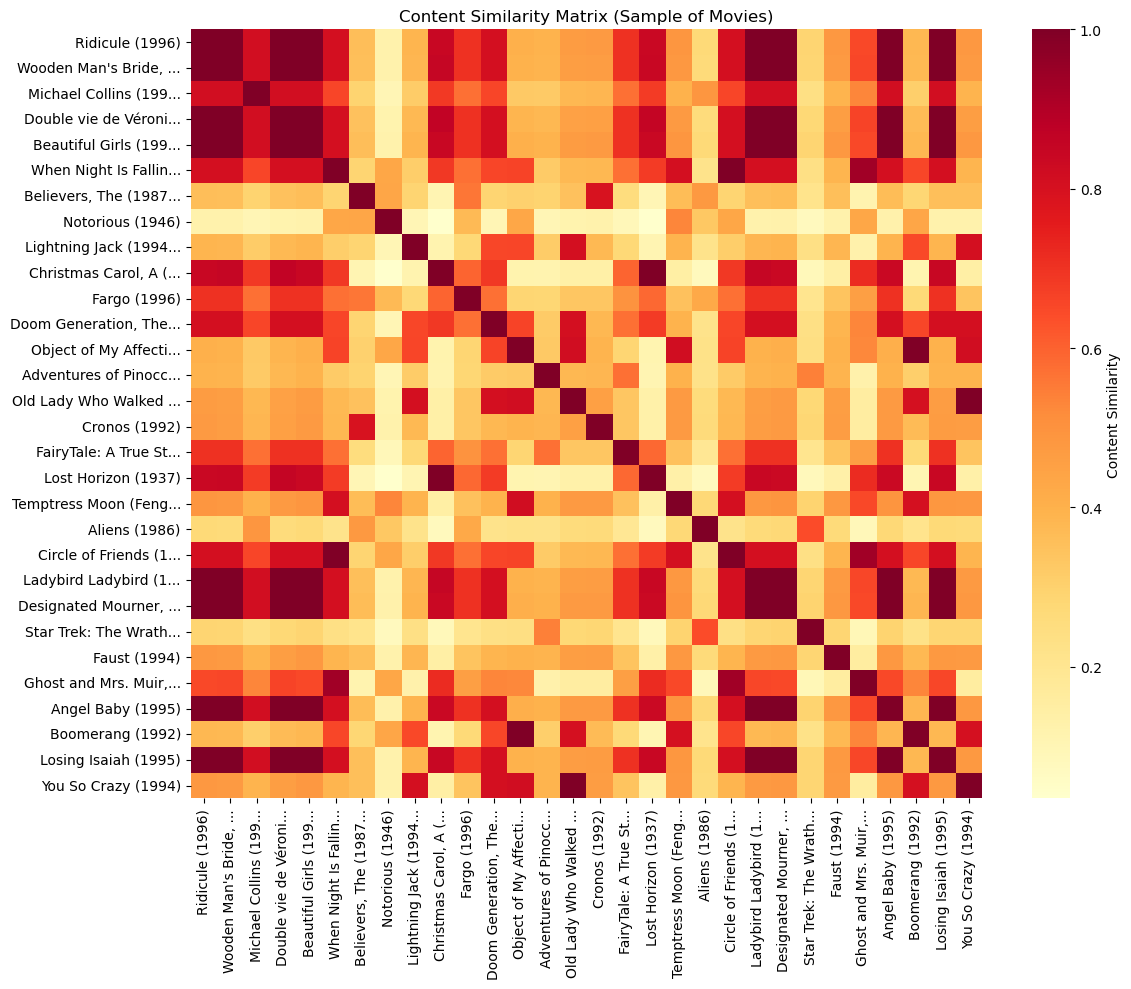

In [39]:
# Visualize content similarity
def visualize_genre_similarity(content_rec, sample_size=50):
    """Visualize similarity between movies based on content"""
    # Sample movies for visualization
    sample_indices = np.random.choice(len(movies_df), sample_size, replace=False)
    sample_similarities = content_rec.item_similarities[sample_indices][:, sample_indices]

    # Create labels with movie titles (truncated)
    sample_movies = movies_df.iloc[sample_indices]
    labels = [title[:20] + '...' if len(title) > 20 else title
              for title in sample_movies['title'].values]

    # Plot heatmap
    plt.figure(figsize=(12, 10))
    sns.heatmap(sample_similarities, cmap='YlOrRd',
                xticklabels=labels, yticklabels=labels,
                cbar_kws={'label': 'Content Similarity'})
    plt.title('Content Similarity Matrix (Sample of Movies)')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

visualize_genre_similarity(content_rec, sample_size=30)

---

## Part 5: Evaluation with Precision and Recall

Proper evaluation is crucial for understanding which algorithms work best for your specific use case. In this section, we'll implement standard recommendation metrics and compare our different approaches to determine their relative strengths and weaknesses.

#### 5.1 Implementing Precision@K and Recall@K

In [40]:
def precision_recall_at_k(actual_items, predicted_items, k=10):
    """
    Calculate precision and recall at k for a single user.
    - actual_items: set or list of relevant items (ground truth)
    - predicted_items: list of items recommended, ordered by predicted score
    - k: number of top recommendations to consider
    """
    predicted_items_at_k = predicted_items[:k]

    actual_set = set(actual_items)
    predicted_set = set(predicted_items_at_k)

    # Nombre d’éléments pertinents retrouvés dans les recommandations
    nb_true_positives = len(actual_set & predicted_set)

    # Precision@K
    precision = nb_true_positives / k if k > 0 else 0.0

    # Recall@K
    recall = nb_true_positives / len(actual_set) if len(actual_set) > 0 else 0.0

    return precision, recall

def evaluate_recommender_precision_recall(recommender, test_data, k_values=[5, 10, 20]):
    """Evaluate a recommender system using precision and recall at different K values"""
    results = {}
    test_users = test_data['user_id'].unique()[:100]  # Sample for speed

    for k in k_values:
        precisions, recalls = [], []

        for user_id in test_users:
            # Get user's highly-rated test items
            user_test_items = test_data[
                (test_data['user_id'] == user_id) & (test_data['rating'] >= 4)
            ]['item_id'].values

            if len(user_test_items) == 0:
                continue

            # Get recommendations
            try:
                recommendations = recommender.recommend_for_user(user_id, n=k)
                predicted_items = recommendations['item_id'].values if len(recommendations) > 0 else []
            except:
                continue

            # Calculate metrics
            precision, recall = precision_recall_at_k(user_test_items, predicted_items, k)
            precisions.append(precision)
            recalls.append(recall)

        # Store results
        if precisions:
            results[f'precision@{k}'] = np.mean(precisions)
            results[f'recall@{k}'] = np.mean(recalls)
            prec, rec = results[f'precision@{k}'], results[f'recall@{k}']
            results[f'f1@{k}'] = 2 * prec * rec / (prec + rec) if (prec + rec) > 0 else 0
        else:
            results[f'precision@{k}'] = results[f'recall@{k}'] = results[f'f1@{k}'] = 0.0

    return results

In [41]:
# Re-train models on train data
pop_rec = PopularityRecommender(min_ratings=50).fit(train_data)
content_rec = ContentBasedRecommender(movies_enhanced, movie_features).fit(train_data)
cf_rec = UserBasedCFRecommender(n_similar_users=50).fit(train_data)
svd_rec = SVDRecommender(n_factors=50).fit(train_data)

print("✅ All models trained!")

✅ All models trained!


In [42]:
print("📊 Evaluating algorithms with Precision@K and Recall@K:\n")

algorithms = {
    'Popularity-Based': pop_rec,
    'Content-Based': content_rec,
    'User-Based CF': cf_rec,
    'SVD (Matrix Factorization)': svd_rec
}

evaluation_results = {}
for name, recommender in algorithms.items():
    print(f"Evaluating {name}...")
    results = evaluate_recommender_precision_recall(recommender, test_data, k_values=[5, 10, 20])
    evaluation_results[name] = results
    print(f"{name}: Precision@10={results['precision@10']:.3f}, Recall@10={results['recall@10']:.3f}")

📊 Evaluating algorithms with Precision@K and Recall@K:

Evaluating Popularity-Based...
Popularity-Based: Precision@10=0.096, Recall@10=0.071
Evaluating Content-Based...
Content-Based: Precision@10=0.066, Recall@10=0.043
Evaluating User-Based CF...
User-Based CF: Precision@10=0.385, Recall@10=0.228
Evaluating SVD (Matrix Factorization)...
SVD (Matrix Factorization): Precision@10=0.333, Recall@10=0.209


#### 5.2 Comprehensive Evaluation Framework

In [43]:
def evaluate_recommender_comprehensive(recommender, test_data, k_values=[5, 10, 20]):
    """
    Evaluate recommender on multiple metrics and different K values
    """
    results = defaultdict(dict)

    # Get unique users in test set
    test_users = test_data['user_id'].unique()[:100]  # Sample for speed

    for k in k_values:
        all_precisions = []
        all_recalls = []
        recommended_items = set()

        for user_id in test_users:
            # Get user's test items (items they rated highly)
            user_test_items = test_data[
                (test_data['user_id'] == user_id) &
                (test_data['rating'] >= 4)
            ]['item_id'].values

            if len(user_test_items) == 0:
                continue

            # Get recommendations
            try:
                recs = recommender.recommend_for_user(user_id, n=k)
                rec_items = recs['item_id'].values
            except Exception as e:
                # Skip if recommender fails (e.g., user not in training data)
                continue

            # Calculate metrics
            hits = len(set(rec_items) & set(user_test_items))
            precision = hits / k if k > 0 else 0
            recall = hits / len(user_test_items) if len(user_test_items) > 0 else 0

            all_precisions.append(precision)
            all_recalls.append(recall)
            recommended_items.update(rec_items)

        # Store results
        results[k]['precision'] = np.mean(all_precisions) if all_precisions else 0
        results[k]['recall'] = np.mean(all_recalls) if all_recalls else 0
        results[k]['f1'] = 2 * results[k]['precision'] * results[k]['recall'] / \
                          (results[k]['precision'] + results[k]['recall']) \
                          if (results[k]['precision'] + results[k]['recall']) > 0 else 0
        results[k]['coverage'] = len(recommended_items) / len(test_data['item_id'].unique())

    return dict(results)

In [44]:
# Evaluate all recommenders
print("\n📊 Comprehensive Evaluation Results:\n")

# Use your trained recommenders with unified interface
recommenders = {
    'Popularity': pop_rec,
    'Content-Based': content_rec,
    'CF User-Based': cf_rec,
    'SVD Matrix Factorization': svd_rec
}

for name, rec in recommenders.items():
    print(f"\n{name} Recommender:")
    results = evaluate_recommender_comprehensive(rec, test_data)

    # Display results in a nice table
    metrics_df = pd.DataFrame(results).T
    metrics_df.index.name = 'K'
    print(metrics_df.round(3))


📊 Comprehensive Evaluation Results:


Popularity Recommender:
    precision  recall   f1  coverage
K                                   
5        0.11    0.04 0.05      0.00
10       0.10    0.07 0.08      0.01
20       0.09    0.13 0.11      0.01

Content-Based Recommender:
    precision  recall   f1  coverage
K                                   
5        0.06    0.02 0.03      0.16
10       0.07    0.04 0.05      0.25
20       0.06    0.07 0.07      0.39

CF User-Based Recommender:
    precision  recall   f1  coverage
K                                   
5        0.44    0.14 0.21      0.06
10       0.39    0.23 0.29      0.10
20       0.29    0.32 0.30      0.17

SVD Matrix Factorization Recommender:
    precision  recall   f1  coverage
K                                   
5        0.40    0.13 0.19      0.16
10       0.33    0.21 0.26      0.24
20       0.26    0.30 0.28      0.31


#### 5.3 Visualizing Performance Trade-offs

In [50]:
def plot_precision_recall_curves(recommenders_results):
    """
    Plot precision-recall curves for different recommenders
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot 1: Precision and Recall vs K
    k_values = [5, 10, 20]

    # Use the evaluation results we already have
    for name, results in evaluation_results.items():
        precisions = [results[f'precision@{k}'] for k in k_values]
        recalls = [results[f'recall@{k}'] for k in k_values]

        ax1.plot(k_values, precisions, marker='o', label=f'{name} (Precision)')
        ax1.plot(k_values, recalls, marker='s', linestyle='--', label=f'{name} (Recall)')

    ax1.set_xlabel('K (Number of Recommendations)')
    ax1.set_ylabel('Score')
    ax1.set_title('Precision and Recall vs K')
    ax1.legend()
    ax1.grid(True)

    # Plot 2: Precision vs Recall trade-off
    for name, results in evaluation_results.items():
        k_values_extended = [5, 10, 15, 20]
        precisions = []
        recalls = []

        for k in k_values_extended:
            if f'precision@{k}' in results:
                precisions.append(results[f'precision@{k}'])
                recalls.append(results[f'recall@{k}'])

        ax2.plot(recalls, precisions, marker='o', label=name)

    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    ax2.set_title('Precision-Recall Trade-off')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

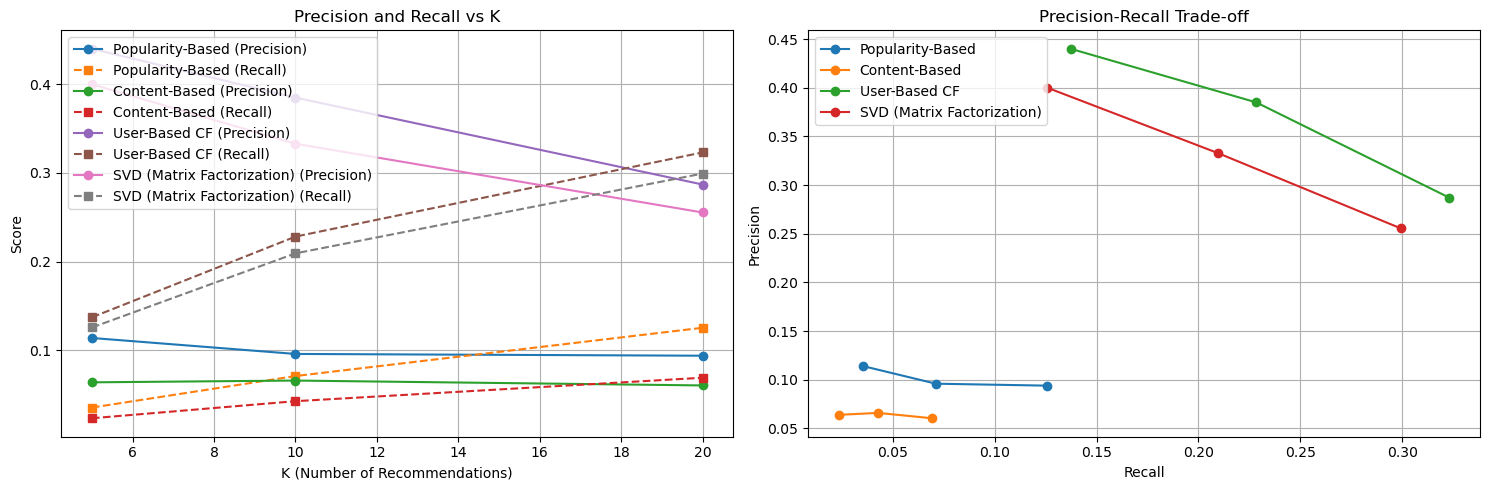

In [51]:
plot_precision_recall_curves(evaluation_results)

---

## Part 6: Production Considerations

Moving beyond algorithmic metrics, this section focuses on preparing systems for production deployment. We'll build a production-ready service with proper error handling and monitoring.

#### 6.1 Production Deployment Considerations


In [57]:
class RecommendationService:
    """
    Production-ready recommendation service with caching and monitoring
    """
    def __init__(self, models_dict, movies_df):
        self.models = models_dict
        self.movies_df = movies_df
        self.cache = {}
        self.metrics = defaultdict(int)

    def get_recommendations(self, user_id, algorithm='content', n=10, use_cache=True):
        """
        Get recommendations with fallback strategies
        """
        start_time = datetime.now()

        # TODO: Implement caching, if `use_cache` is True
        # 1. Create cache key from user_id, algorithm, and n
        # 2. Check if key exists in self.cache
        # 3. Update cache hit/miss metrics, under `cache['cache_hits']` and `cache['cache_misses']`
        # 4. Return cached result if available
        # YOUR CODE HERE
        cache_key = (user_id, algorithm, n)
        if use_cache:
            if cache_key in self.cache:
                self.metrics['cache_hits'] += 1
                return self.cache[cache_key]
            else:
                self.metrics['cache_misses'] += 1

        # If result not available in cache, compute recommendations
        try:
            if algorithm in self.models:
                recs = self.models[algorithm].recommend_for_user(user_id, n=n)
            else:
                raise ValueError(f"Unknown algorithm: {algorithm}")
        except Exception as e:
            # Fallback to popularity
            self.metrics['fallbacks'] += 1
            recs = self.models['popularity'].recommend_for_user(user_id, n=n)

        # Add movie titles if not present
        if len(recs) > 0:
            recs = add_movie_titles(recs, movies_df)

        # TODO: Cache computed recommendations, if `use_cache` is True
        # YOUR CODE HERE
        if use_cache:
            self.cache[cache_key] = recs
            
        # Record metrics
        response_time = (datetime.now() - start_time).total_seconds()
        self.metrics['total_requests'] += 1
        self.metrics['avg_response_time'] = (
            (self.metrics['avg_response_time'] * (self.metrics['total_requests'] - 1) + response_time)
            / self.metrics['total_requests']
        )

        return recs

    def get_metrics_summary(self):
        """Get service metrics"""
        return {
            'total_requests': self.metrics['total_requests'],
            'cache_hit_rate': self.metrics['cache_hits'] / self.metrics['total_requests']
                             if self.metrics['total_requests'] > 0 else 0,
            'fallback_rate': self.metrics['fallbacks'] / self.metrics['total_requests']
                            if self.metrics['total_requests'] > 0 else 0,
            'avg_response_time_ms': self.metrics['avg_response_time'] * 1000
        }

In [58]:
service = RecommendationService({
    'content': content_rec,
    'popularity': pop_rec
}, movies_df)

# Simulate production usage
print("\n🚀 Simulating Production Usage:\n")

# Different user scenarios
test_scenarios = [
    {'user_id': 1, 'algorithm': 'content'},     # Normal user
    {'user_id': 1, 'algorithm': 'content'},     # Cached request
    {'user_id': 50, 'algorithm': 'popularity'}, # Popularity-based
    {'user_id': 9999, 'algorithm': 'content'},  # New user (will fallback)
]

for scenario in test_scenarios:
    recs = service.get_recommendations(**scenario)
    print(f"User {scenario['user_id']} ({scenario['algorithm']}): {len(recs)} recommendations")

print("\n📊 Service Metrics:")
for metric, value in service.get_metrics_summary().items():
    if 'rate' in metric:
        print(f"  {metric}: {value:.2%}")
    elif 'time' in metric:
        print(f"  {metric}: {value:.2f}")
    else:
        print(f"  {metric}: {value}")


🚀 Simulating Production Usage:

User 1 (content): 10 recommendations
User 1 (content): 10 recommendations
User 50 (popularity): 10 recommendations
User 9999 (content): 0 recommendations

📊 Service Metrics:
  total_requests: 3
  cache_hit_rate: 33.33%
  fallback_rate: 0.00%
  avg_response_time_ms: 41.05


## Part 7: Key Takeaways and Discussion

Finally, we'll synthesize our findings into actionable business recommendations and strategic insights. This section provides a framework for choosing the right approach for different scenarios and discusses important considerations for real-world implementation.

#### 7.1 Algorithm Comparison Summary

In [59]:
# Create a comprehensive comparison
print("🎯 ALGORITHM COMPARISON SUMMARY:\n")

comparison_data = {
    'Algorithm': ['Popularity', 'Content-Based', 'User-Based CF', 'SVD (Matrix Factorization)'],
    'Cold Start (New Users)': ['✅ Excellent', '✅ Excellent', '❌ Poor', '❌ Poor'],
    'Cold Start (New Items)': ['❌ Poor', '✅ Excellent', '❌ Poor', '❌ Poor'],
    'Scalability': ['✅ Excellent', '✅ Good', '⚠️ Moderate', '✅ Good'],
    'Interpretability': ['✅ High', '✅ High', '⚠️ Moderate', '❌ Low'],
    'Personalization': ['❌ None', '⚠️ Moderate', '✅ High', '✅ High'],
    'Data Requirements': ['Low', 'Item Features', 'User-Item Ratings', 'User-Item Ratings']
}

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False))

🎯 ALGORITHM COMPARISON SUMMARY:

                 Algorithm Cold Start (New Users) Cold Start (New Items) Scalability Interpretability Personalization Data Requirements
                Popularity            ✅ Excellent                 ❌ Poor ✅ Excellent           ✅ High          ❌ None               Low
             Content-Based            ✅ Excellent            ✅ Excellent      ✅ Good           ✅ High     ⚠️ Moderate     Item Features
             User-Based CF                 ❌ Poor                 ❌ Poor ⚠️ Moderate      ⚠️ Moderate          ✅ High User-Item Ratings
SVD (Matrix Factorization)                 ❌ Poor                 ❌ Poor      ✅ Good            ❌ Low          ✅ High User-Item Ratings


#### 7.2 Business Recommendations


In [62]:
print("\n📋 KEY BUSINESS RECOMMENDATIONS:\n")

recommendations = [
    "1. 🚀 Start Simple: Begin with popularity-based recommendations as a baseline",
    "2. 🎯 Hybrid Approach: Combine content-based for new items with CF for personalization",
    "3. 📊 Measure Everything: Track both algorithmic metrics (precision/recall) and business KPIs",
    "4. 🔄 Continuous Improvement: A/B test different algorithms and parameters",
    "5. ⚡ Performance Matters: Cache recommendations and pre-compute when possible",
    "6. 🎨 Diversity is Key: Don't just optimize for accuracy - consider novelty and diversity",
    "7. 🛡️ Plan for Failures: Always have a fallback strategy (e.g., popularity)"
]

for rec in recommendations:
    print(rec)

print("\n💭 DISCUSSION QUESTIONS:")
questions = [
    "- How would you handle recommendations for a brand new streaming service with no data?",
    "- What additional features could improve content-based recommendations?",
    "- How do you balance exploitation (recommending sure hits) vs exploration (discovering new content)?",
    "- How would you detect and mitigate filter bubbles?"
]

for question in questions:
    print(question)


📋 KEY BUSINESS RECOMMENDATIONS:

1. 🚀 Start Simple: Begin with popularity-based recommendations as a baseline
2. 🎯 Hybrid Approach: Combine content-based for new items with CF for personalization
3. 📊 Measure Everything: Track both algorithmic metrics (precision/recall) and business KPIs
4. 🔄 Continuous Improvement: A/B test different algorithms and parameters
5. ⚡ Performance Matters: Cache recommendations and pre-compute when possible
6. 🎨 Diversity is Key: Don't just optimize for accuracy - consider novelty and diversity
7. 🛡️ Plan for Failures: Always have a fallback strategy (e.g., popularity)

💭 DISCUSSION QUESTIONS:
- How would you handle recommendations for a brand new streaming service with no data?
- What additional features could improve content-based recommendations?
- How do you balance exploitation (recommending sure hits) vs exploration (discovering new content)?
- How would you detect and mitigate filter bubbles?


#### 🏁 Lab Complete!


In [54]:
print("""
🎉 Congratulations! You've built a complete recommendation system!

✅ What you've accomplished:
- Analyzed real user behavior data
- Implemented popularity-based, content-based, and collaborative filtering
- Evaluated algorithms using precision and recall metrics
- Considered production deployment challenges
- Analyzed business impact

📚 Next steps:
1. Try combining content-based and collaborative filtering in a hybrid approach
2. Experiment with deep learning methods (neural collaborative filtering)
3. Add contextual features (time of day, device type)
4. Implement online learning for real-time adaptation
""")


🎉 Congratulations! You've built a complete recommendation system!

✅ What you've accomplished:
- Analyzed real user behavior data
- Implemented popularity-based, content-based, and collaborative filtering
- Evaluated algorithms using precision and recall metrics
- Considered production deployment challenges
- Analyzed business impact

📚 Next steps:
1. Try combining content-based and collaborative filtering in a hybrid approach
2. Experiment with deep learning methods (neural collaborative filtering)
3. Add contextual features (time of day, device type)
4. Implement online learning for real-time adaptation

